In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
from geopy.distance import geodesic
import math
import seaborn as sns

from scipy import stats
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr, chi2_contingency, linregress
from scipy.spatial import cKDTree

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [2]:
bikes = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/bluebikes_2021.csv")
weather = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/boston_weather.csv")
pois = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/pois.csv")

C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\4071934133.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  bikes = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/bluebikes_2021.csv")
C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\4071934133.py:3: DtypeWarning: Columns (10,12,13,14,21,22,25,26,28,29,31,32,33,34,35,36,37,39,40,41,43,44,45,48,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,74,75,76,77,78,79,80,81,82,84,85,88,89,90,91,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  pois = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/pois.csv")


# Data Collection and Preparation


## Bluebikes 

In [3]:
bikes.info()
bikes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   start_time         object 
 2   end_time           object 
 3   start_station_id   int64  
 4   start_station_lat  float64
 5   start_station_lon  float64
 6   end_station_id     object 
 7   end_station_lat    float64
 8   end_station_lon    float64
 9   bike_id            int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 223.9+ MB


,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062
...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484


#### Change 'start_time' and 'end_time' from object to datetime

In [4]:
# We want to change the data type of the variables start_time and end_time from objects to datetime
# In order to do that first we have to deal with the inconsistencies in the columns start_time and end_time 
# Some of the entries don't follow the format year-month-day; hours:minutes:seconds, so we need to change the format
# by creating a function that replaces the slashes (/) with colons (:) of some values 

def substitute_slashes(data, column):
    data[column] = data[column].str.replace('/', ':')
    return data

substitute_slashes(bikes, 'start_time')
substitute_slashes(bikes, 'end_time')

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062
...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484


In [5]:
# Now we can transform the start_time and end_time columns to the proper format with the pd.to_datatime method

bikes[['start_time','end_time']] = bikes[['start_time','end_time']].apply(pd.to_datetime)

In [6]:
# We can use the info() method to assure that the data types of the variables start_time and end_time have been changed

bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     object        
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 223.9+ MB


#### Change 'end_station_id' to integer

In [7]:
# We also want to change the data type of the variable end_station_id to an integer (it should be the same as start_station_id)
# This inconsistency is because some of the values in the column end_station_id are not in the proper format,
# instead of being whole numers some of them have quote symbols (""), which makes transform the column into an object type
# We create a function that eliminates the quote marks of the numbers

def remove_quotes(data, column):
    data[column] = data[column].apply(lambda x: x.replace('"', '') if isinstance(x, str) else x)
    return data

bikes = remove_quotes(bikes, 'end_station_id')

In [8]:
# Once all the values in the column have the same format then we can proceed to transform the data type of the variable to integer

bikes['end_station_id'] = bikes['end_station_id'].apply('int64')

In [9]:
# We can use the info() method to confirm that the type of the variable 'end_station_id' has been changed

bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     int64         
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 223.9 MB


#### Account for time change

In [10]:
# We want to create a new variable that contains the average idle time of a bike for each station 
# First we want to eliminate those entries with the change of hour

# We exclude the times of change of hour
start_time_range_1 = pd.Timestamp('2021-03-14 02:00:00')
end_time_range_1 = pd.Timestamp('2021-03-14 03:00:00')
start_time_range_2 = pd.Timestamp('2021-11-07 01:00:00')
end_time_range_2 = pd.Timestamp('2021-11-07 02:00:00')

# Create boolean masks to filter out the entries within the specified time ranges
mask_range_1 = (bikes['start_time'].between(start_time_range_1, end_time_range_1)) | (bikes['end_time'].between(start_time_range_1, end_time_range_1))
mask_range_2 = (bikes['start_time'].between(start_time_range_2, end_time_range_2)) | (bikes['end_time'].between(start_time_range_2, end_time_range_2))

# Apply the masks to exclude the entries within the specified time ranges
bikes = bikes[~(mask_range_1 | mask_range_2)]

#### Calculate the duration of each trip 

In [11]:
bikes['duration'] = (bikes['end_time'] - bikes['start_time']).dt.total_seconds() / 60 
bikes

C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\377344393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['duration'] = (bikes['end_time'] - bikes['start_time']).dt.total_seconds() / 60


,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,duration
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316,15.250000
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917,18.100000
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881,15.766667
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792,5.933333
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062,8.533333
...,...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895,8.000000
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665,12.633333
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470,4.683333
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484,1.983333


In [12]:
# We remove major outliers from the data (trips longer than 6 hours)

bikes['duration'].quantile(0.995)
bikes = bikes[bikes.duration <= 360]

# we went from 2934388 rows to 2926307

#### Calculate peak hours

C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\2883827729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['start_hour'] = bikes['start_time'].dt.hour


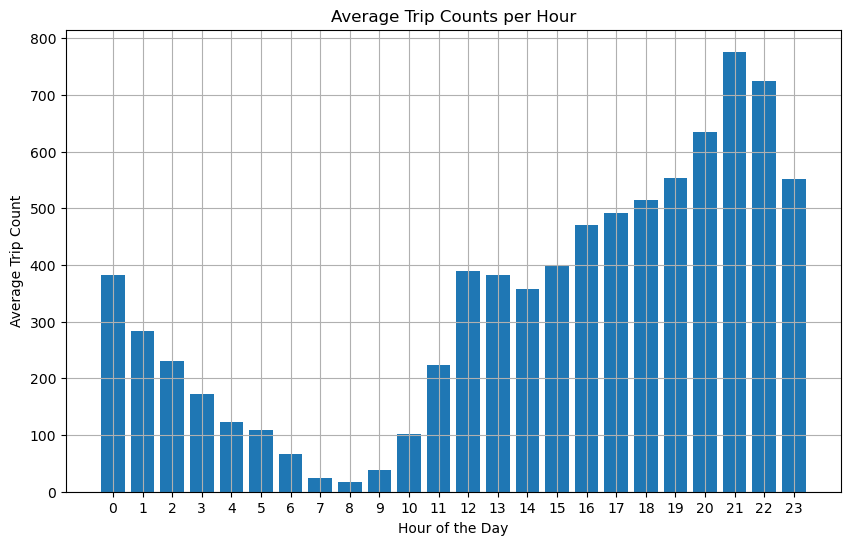

,hour,average_trip_count_per_hour
0,0,382.0
1,1,284.0
2,2,231.0
3,3,173.0
4,4,123.0
5,5,109.0
6,6,66.0
7,7,25.0
8,8,17.0
9,9,38.0


In [13]:
# Step 1: Extract the hour of the day from the "start_time" column
bikes['start_hour'] = bikes['start_time'].dt.hour

# Step 2: Calculate the average number of bike trips for each hour
hourly_trip_counts = bikes.groupby('start_hour')['bike_id'].count().reset_index()
hourly_trip_counts.columns = ['hour', 'total_trip_count']

# Step 3: Calculate the average number of trips for each hour by dividing the total_trip_count by the number of days
number_of_days = bikes['start_time'].dt.date.nunique()
hourly_trip_counts['average_trip_count_per_hour'] = hourly_trip_counts['total_trip_count'] / number_of_days

# Step 4: Round the average trip counts to the nearest whole number
hourly_trip_counts['average_trip_count_per_hour'] = hourly_trip_counts['average_trip_count_per_hour'].round()

# Step 5: Plot a bar graph to visualize the average trip counts for each hour
plt.figure(figsize=(10, 6))
plt.bar(hourly_trip_counts['hour'], hourly_trip_counts['average_trip_count_per_hour'])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Count')
plt.title('Average Trip Counts per Hour')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Step 6: Store the average trip counts per hour in a new data frame
average_trip_count_per_hour = hourly_trip_counts[['hour', 'average_trip_count_per_hour']].copy()

average_trip_count_per_hour

#### Create variable 'idle_time'

In [14]:
# First we need to calculate the idle time for every bike

# 1. We sort the data by bike_id and end_time
bikes.sort_values(['bike_id', 'end_time'], inplace=True)

# 2. Group the data by bike_id
grouped = bikes.groupby('bike_id')

# 3. Calculate the idle time for each bike by subtracting end_time to start_time and store in a new variable called idle_time
bikes['idle_time'] = grouped['start_time'].shift(-1) - bikes['end_time']

# 4. Set the idle time to 0 for the last bike usage
bikes.loc[grouped['bike_id'].cumcount() == grouped['bike_id'].transform('size') - 1, 'idle_time'] = pd.Timedelta(0)

# 5. Reset the dataframe index
bikes.reset_index(drop=True, inplace=True)

C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\1869849024.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes.sort_values(['bike_id', 'end_time'], inplace=True)
C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\1869849024.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['idle_time'] = grouped['start_time'].shift(-1) - bikes['end_time']


In [15]:
bikes['idle_time_minutes'] = bikes['idle_time'].dt.total_seconds() / 60
bikes['idle_time_minutes'] = bikes['idle_time_minutes'].astype(int)

bikes[['bike_id', 'start_station_id','end_station_id','idle_time_minutes']]

C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\2054574570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['idle_time_minutes'] = bikes['idle_time'].dt.total_seconds() / 60
C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\2054574570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['idle_time_minutes'] = bikes['idle_time_minutes'].astype(int)


,bike_id,start_station_id,end_station_id,idle_time_minutes
0,218,171,397,3788
1,218,397,176,374
2,218,176,76,36
3,218,76,54,69
4,218,54,56,5448
...,...,...,...,...
2925767,7665,74,333,1895
2925768,7665,333,76,7
2925769,7665,76,189,2803
2925770,7665,116,68,1


In [16]:
# we want to get rid of the outliers (those with idle time too high or unusual)

# Step 1: Calculate the Z-score for the 'idle_time_minutes' variable
z_scores_idle_time = (bikes['idle_time_minutes'] - bikes['idle_time_minutes'].mean()) / bikes['idle_time_minutes'].std()

# Step 2: Set a threshold for outlier removal (e.g., Z-score greater than 3 or less than -3)
outlier_threshold = 3

# Step 3: Filter the 'bikes' data frame to remove outliers and create a new data frame without outliers
bikes_without_outliers = bikes[abs(z_scores_idle_time) <= outlier_threshold]

# Step 4: Update the 'bikes' data frame to contain only rows without outliers
bikes = bikes_without_outliers.copy()

In [17]:
# Second we want to sum all the idle time for every station

# 1. Sort for end_station_id
bikes.sort_values(['end_station_id'], inplace=True)

# 2. Group the data by end_station_id and calculate the sum of idle time
station_idle_sum = bikes.groupby('end_station_id')['idle_time_minutes'].sum()

# 3. Reset the index and rename the columns
station_idle_sum = station_idle_sum.reset_index()
station_idle_sum.columns = ['station_id', 'idle_time_sum']

# Now we have the total idle time for every station
station_idle_sum

,station_id,idle_time_sum
0,1,676508
1,3,3626352
2,4,5407780
3,5,2401016
4,6,3465443
...,...,...
422,548,8689
423,549,1500818
424,550,167922
425,553,496286


In [18]:
# We also want the mean idle time of every station for every day, so we group the data by end_station_id 
# and calculate the average idle time
station_idle_mean = bikes.groupby('end_station_id')['idle_time'].mean()

# Reset the index and rename the columns
station_idle_mean = station_idle_mean.reset_index()
station_idle_mean.columns = ['station_id', 'idle_time_mean']

# We convert the idle time to hours 
station_idle_mean['idle_time_mean'] = (station_idle_mean['idle_time_mean'].dt.total_seconds() / 60).round()

# Now we have the mean idle time in hours for every station

station_idle_mean

,station_id,idle_time_mean
0,1,2169.0
1,3,395.0
2,4,442.0
3,5,165.0
4,6,166.0
...,...,...
422,548,1242.0
423,549,558.0
424,550,639.0
425,553,923.0


In [19]:
# Now we want to create a data frame that contains all the station_id with their respective latitudes and longitudes and
# that then we will merge with all the idle time information

station_ids = sorted(pd.concat([bikes['start_station_id'], bikes['end_station_id']]).unique())
stations = pd.DataFrame({'station_id': station_ids})

stations['lat'] = 0.0
stations['lon'] = 0.0

for index, row in stations.iterrows():
    station_id = row['station_id']
    station_data = bikes[(bikes['start_station_id'] == station_id) | (bikes['end_station_id'] == station_id)].iloc[0]
    if station_data['start_station_id'] == station_id:
        stations.loc[index, 'lat'] = station_data['start_station_lat']
        stations.loc[index, 'lon'] = station_data['start_station_lon']
    else:
        stations.loc[index, 'lat'] = station_data['end_station_lat']
        stations.loc[index, 'lon'] = station_data['end_station_lon']  

In [20]:
# We merge all data sets into a new data frame 

stations = stations.assign(idle_time_sum=station_idle_sum['idle_time_sum'],
                           idle_time_mean=station_idle_mean['idle_time_mean'])
stations

,station_id,lat,lon,idle_time_sum,idle_time_mean
0,1,42.387151,-71.075978,676508,2169.0
1,3,42.340115,-71.100619,3626352,395.0
2,4,42.345392,-71.069616,5407780,442.0
3,5,42.341814,-71.090179,2401016,165.0
4,6,42.361257,-71.065287,3465443,166.0
...,...,...,...,...,...
422,548,42.268100,-71.119240,8689,1242.0
423,549,42.364739,-71.059349,1500818,558.0
424,550,42.386400,-71.096010,167922,639.0
425,553,42.371141,-71.076198,496286,923.0


In [21]:
# We want to calculate the daily average idle time for each station

bikes['date'] = bikes['start_time'].dt.date

# Step 2: Calculate the daily mean idle time for each station
daily_mean_idle_time = bikes.groupby(['start_station_id', 'date'])['idle_time_minutes'].mean().reset_index()

# Step 3: Calculate the mean of the daily mean idle time for each station
station_daily_mean_idle_time = daily_mean_idle_time.groupby('start_station_id')['idle_time_minutes'].mean().reset_index()

# Step 4: Merge the mean idle time with the stations data frame
stations = pd.merge(stations, station_daily_mean_idle_time, left_on='station_id', right_on='start_station_id', how='left')

# Drop the 'start_station_id' column as it is no longer needed
stations.drop(columns=['start_station_id'], inplace=True)

# Rename the new variable to 'daily_idle_time_mean'
stations.rename(columns={'idle_time_minutes': 'daily_idle_time_mean'}, inplace=True)


In [22]:
stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,daily_idle_time_mean
0,1,42.387151,-71.075978,676508,2169.0,1053.608384
1,3,42.340115,-71.100619,3626352,395.0,554.414319
2,4,42.345392,-71.069616,5407780,442.0,579.618493
3,5,42.341814,-71.090179,2401016,165.0,318.315866
4,6,42.361257,-71.065287,3465443,166.0,503.323736
...,...,...,...,...,...,...
422,548,42.268100,-71.119240,8689,1242.0,3050.250000
423,549,42.364739,-71.059349,1500818,558.0,584.315169
424,550,42.386400,-71.096010,167922,639.0,699.711650
425,553,42.371141,-71.076198,496286,923.0,555.502301


#### Calculate the average daily trips for each station 

In [23]:
# Step 1: Calculate the total number of trips for each station in the "bikes" data frame

total_trips_per_station = bikes.groupby('start_station_id')['bike_id'].count().reset_index()
total_trips_per_station = total_trips_per_station.rename(columns={'bike_id': 'total_trips'})

# Step 2: Merge the total trips with the "stations" data frame

stations = pd.merge(stations, total_trips_per_station, left_on='station_id', right_on='start_station_id', how='left')

# Drop the duplicated station_id column after merging

stations.drop(columns=['start_station_id'], inplace=True)

stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,daily_idle_time_mean,total_trips
0,1,42.387151,-71.075978,676508,2169.0,1053.608384,236
1,3,42.340115,-71.100619,3626352,395.0,554.414319,8675
2,4,42.345392,-71.069616,5407780,442.0,579.618493,11996
3,5,42.341814,-71.090179,2401016,165.0,318.315866,14320
4,6,42.361257,-71.065287,3465443,166.0,503.323736,21104
...,...,...,...,...,...,...,...
422,548,42.268100,-71.119240,8689,1242.0,3050.250000,4
423,549,42.364739,-71.059349,1500818,558.0,584.315169,2714
424,550,42.386400,-71.096010,167922,639.0,699.711650,425
425,553,42.371141,-71.076198,496286,923.0,555.502301,698


In [24]:
# we now get rid of the outliers of total trips

# Step 1: Calculate the Z-score for the 'total_trip_count' variable
z_scores_total_trips = (stations['total_trips'] - stations['total_trips'].mean()) / stations['total_trips'].std()

# Step 2: Set a threshold for outlier removal (e.g., Z-score greater than 3 or less than -3)
outlier_threshold = 3

# Step 3: Filter the 'stations' data frame to remove outliers and create a new data frame without outliers
stations_without_outliers = stations[abs(z_scores_total_trips) <= outlier_threshold]

# Step 4: Update the 'stations' data frame to contain only rows without outliers
stations = stations_without_outliers.copy()

In [25]:

# Step 2: Calculate the total number of trips for each station for each day
total_trips_per_station_daily = bikes.groupby(['start_station_id', 'date'])['bike_id'].count().reset_index()
total_trips_per_station_daily = total_trips_per_station_daily.rename(columns={'bike_id': 'total_trips_daily'})

# Step 3: Calculate the average daily trips for each station
average_daily_trips_per_station = total_trips_per_station_daily.groupby('start_station_id')['total_trips_daily'].mean().reset_index()
average_daily_trips_per_station = average_daily_trips_per_station.rename(columns={'total_trips_daily': 'avg_daily_trips'})

# Step 4: Merge the average daily trips with the "stations" data frame
stations = pd.merge(stations, average_daily_trips_per_station, left_on='station_id', right_on='start_station_id', how='left')
stations.drop(columns=['start_station_id'], inplace=True)

stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,daily_idle_time_mean,total_trips,avg_daily_trips
0,1,42.387151,-71.075978,676508,2169.0,1053.608384,236,1.447853
1,3,42.340115,-71.100619,3626352,395.0,554.414319,8675,23.832418
2,4,42.345392,-71.069616,5407780,442.0,579.618493,11996,32.956044
3,5,42.341814,-71.090179,2401016,165.0,318.315866,14320,77.826087
4,6,42.361257,-71.065287,3465443,166.0,503.323736,21104,57.819178
...,...,...,...,...,...,...,...,...
415,548,42.268100,-71.119240,8689,1242.0,3050.250000,4,1.000000
416,549,42.364739,-71.059349,1500818,558.0,584.315169,2714,29.500000
417,550,42.386400,-71.096010,167922,639.0,699.711650,425,5.448718
418,553,42.371141,-71.076198,496286,923.0,555.502301,698,11.079365


## Weather

In [26]:
weather.info()
weather

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82777 entries, 0 to 82776
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     82777 non-null  object 
 1   timestamp                82777 non-null  object 
 2   temperature              82773 non-null  float64
 3   cloud_cover              82777 non-null  int64  
 4   cloud_cover_description  82777 non-null  object 
 5   pressure                 82768 non-null  float64
 6   windspeed                82740 non-null  float64
 7   precipitation            82777 non-null  float64
 8   felt_temperature         82752 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 5.7+ MB


,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Boston,2015-01-01 05:54:00,-6.0,29,Partly Cloudy,1018.58,17.0,0.00,-12.0
1,Boston,2015-01-01 06:54:00,-6.0,27,Mostly Cloudy,1017.90,17.0,0.00,-12.0
2,Boston,2015-01-01 07:54:00,-6.0,27,Mostly Cloudy,1017.22,19.0,0.00,-12.0
3,Boston,2015-01-01 08:54:00,-4.0,27,Mostly Cloudy,1016.55,20.0,0.00,-11.0
4,Boston,2015-01-01 09:54:00,-6.0,29,Partly Cloudy,1016.21,24.0,0.00,-13.0
...,...,...,...,...,...,...,...,...,...
82772,Boston,2023-01-01 01:54:00,12.0,11,Light Rain,1007.75,13.0,0.51,12.0
82773,Boston,2023-01-01 02:54:00,11.0,11,Light Rain,1006.73,11.0,1.78,11.0
82774,Boston,2023-01-01 03:54:00,11.0,11,Light Rain,1005.72,11.0,2.29,11.0
82775,Boston,2023-01-01 04:29:00,12.0,11,Light Rain,1005.04,15.0,0.76,12.0


In [27]:
# First we want to change the "timestamp" variable type from object to datetime with pd.to_datetime

weather['timestamp'] = pd.to_datetime(weather['timestamp'])

In [28]:
# Now we filter only the entries for the year 2021, since is the year we are interested in for our project   

weather = weather[weather['timestamp'].dt.year == 2021] 

In [29]:
# We look whether there are any null-values which we want to get rid of

missing_values = weather.isnull().sum() 
print(missing_values)

rows_with_missing_values = weather[weather.isnull().any(axis=1)]
print(rows_with_missing_values)

city                       0
timestamp                  0
temperature                2
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  3
precipitation              0
felt_temperature           2
dtype: int64
         city           timestamp  temperature  cloud_cover  \
63950  Boston 2021-03-03 16:54:00          NaN           34   
66774  Boston 2021-06-17 17:54:00         25.0           34   
68871  Boston 2021-08-24 17:54:00         31.0           28   
70297  Boston 2021-10-14 17:54:00          NaN           34   

      cloud_cover_description  pressure  windspeed  precipitation  \
63950                    Fair   1008.09        NaN            0.0   
66774                    Fair   1011.81        NaN            0.0   
68871           Mostly Cloudy   1011.13        NaN            0.0   
70297                    Fair   1011.47       20.0            0.0   

       felt_temperature  
63950               NaN  
66774       

In [30]:
#  We drop all null-values and check if we successfully got rid of them

weather = weather.dropna()

missing_values = weather.isnull().sum()
print(missing_values)

city                       0
timestamp                  0
temperature                0
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  0
precipitation              0
felt_temperature           0
dtype: int64


## Points of interest

In [31]:
# First we filter only the information for Boston, since we do not need the data of Massachusetts

pois = pois[pois['addr:city'] == "Boston"] 

In [32]:
pois.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 33 to 92230
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1908 non-null   int64  
 1   version             1908 non-null   int64  
 2   timestamp           1908 non-null   int64  
 3   changeset           1610 non-null   float64
 4   id                  1908 non-null   int64  
 5   tags                1861 non-null   object 
 6   lat                 1585 non-null   float64
 7   lon                 1585 non-null   float64
 8   addr:city           1908 non-null   object 
 9   addr:country        16 non-null     object 
 10  addr:full           1 non-null      object 
 11  addr:housenumber    1878 non-null   object 
 12  addr:housename      8 non-null      object 
 13  addr:postcode       1839 non-null   object 
 14  addr:place          1 non-null      object 
 15  addr:street         1900 non-null   object 
 16  emai

In [33]:
pois

,Unnamed: 0,version,timestamp,changeset,id,tags,lat,lon,addr:city,addr:country,...,geometry,osm_type,biergarten,theatre,agrarian,cosmetics,outdoor,swimming_pool,trade,water
33,33,6,1591763622,0.0,69504856,"{""addr:state"":""MA"",""attribution"":""massDOT"",""bu...",42.338516,-71.03127,Boston,NaN,...,POINT (-71.0312728881836 42.33851623535156),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,84,4,1530115928,0.0,257486687,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.299590,-71.10173,Boston,NaN,...,POINT (-71.10173034667969 42.299591064453125),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,90,6,1593727122,0.0,257486695,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.292465,-71.10141,Boston,NaN,...,POINT (-71.10140991210938 42.29246520996094),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,96,5,1596134943,0.0,257486704,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.367275,-71.06633,Boston,NaN,...,POINT (-71.06632995605469 42.36727523803711),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,99,3,1530115932,0.0,257486710,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.334450,-71.06774,Boston,NaN,...,POINT (-71.06774139404297 42.334449768066406),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92220,92220,10,1680275378,0.0,7547154230,"{""addr:state"":""MA"",""site"":""school"",""type"":""site""}",NaN,NaN,Boston,NaN,...,"MULTIPOLYGON (((-71.0829577 42.3490254, -71.08...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92221,92221,5,1596311865,0.0,9405156098,"{""addr:state"":""MA"",""contact:facebook"":""https:/...",NaN,NaN,Boston,NaN,...,"POLYGON ((-71.0784068 42.3501667, -71.0784356 ...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92222,92222,6,1638386222,0.0,9427558974,"{""addr:state"":""MA"",""type"":""multipolygon""}",NaN,NaN,Boston,NaN,...,"MULTIPOLYGON (((-71.030267 42.3720275, -71.030...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92224,92224,5,1644043877,0.0,9696493087,"{""addr:state"":""MA"",""air_conditioning"":""yes"",""b...",NaN,NaN,Boston,NaN,...,"POLYGON ((-71.0841867 42.3458082, -71.0841551 ...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exploring the variables

In [34]:
# We want to explore the different categories of the variables that have more non-null values and we think are more relevant

categories_amenity =  pois['amenity'].unique()
categories_amenity

array(['bus_station', 'prison', 'hospital', 'police', 'school',
       'fire_station', 'library', nan, 'bank', 'post_office',
       'place_of_worship', 'university', 'college', 'parking',
       'restaurant', 'bar', 'cafe', 'pub', 'social_facility',
       'ferry_terminal', 'fast_food', 'cinema', 'parking_entrance',
       'community_centre', 'bicycle_rental', 'clinic', 'bicycle_parking',
       'dentist', 'social_centre', 'pharmacy', 'ice_cream', 'car_rental',
       'nightclub', 'fuel', 'theatre', 'atm', 'boat_rental',
       'planetarium', 'doctors', 'internet_cafe', 'veterinary',
       'concert_hall', 'childcare', 'car_sharing', 'loading_dock',
       'music_venue', 'food_court', 'dojo', 'post_box', 'language_school',
       'kindergarten', 'charging_station', 'biergarten',
       'research_institute', 'telephone', 'vending_machine',
       'payment_terminal', 'music_school', 'studio', 'recycling',
       'marketplace', 'driving_school', 'courthouse', 'post_depot',
       'monast

In [35]:
categories_shop = pois['shop'].unique()
categories_shop 

array([nan, 'hardware', 'car_repair', 'hifi', 'hairdresser', 'outdoor',
       'supermarket', 'clothes', 'books', 'mobile_phone', 'convenience',
       'electronics', 'dry_cleaning', 'music', 'chemist', 'pastry',
       'furniture', 'health_food', 'vacant', 'beauty', 'alcohol',
       'optician', 'bicycle', 'newsagent', 'laundry', 'charity',
       'Athletics', 'locksmith', 'chocolate', 'jewelry', 'wine',
       'massage', 'fashion_accessories', 'bakery', 'florist', 'copyshop',
       'sports', 'outdoor;sports', 'department_store', 'cosmetics',
       'lamps', 'gift', 'yes', 'greengrocer', 'shoes', 'car', 'paint',
       'nutrition_supplements', 'video_games', 'candles', 'tea',
       'interior_decoration', 'tailor', 'bag', 'craft', 'pet', 'bed',
       'leather', 'pet_grooming', 'frame', 'lighting', 'tobacco',
       'pawnbroker', 'watches', 'window_blind', 'baby_goods',
       'confectionery', 'coffee', 'ticket', 'variety_store', 'carpet',
       'stationery', 'perfumery', 'kiosk', '

In [36]:
categories_tourism =  pois['tourism'].unique()
categories_tourism

array([nan, 'museum', 'hotel', 'attraction', 'information', 'gallery',
       'apartment', 'aquarium', 'hostel', 'guest_house', 'viewpoint'],
      dtype=object)

In [37]:
categories_religion = pois['religion'].unique()
categories_religion

array([nan, 'none', 'christian', 'unitarian_universalist', 'jewish',
       'Universalist'], dtype=object)

In [38]:
# After making some exploration we can see that some of the variables are included in other categories
# This overlap makes the information redundant, so we will only choose a specific set of those variables 
# that contain more information and we think are relevant for our analysis

# After making a selection of the columns that we want we create a new dataframe

columns_needed = ['lat','lon','amenity','shop','tourism', 'religion']
new_pois = pois[columns_needed]

In [39]:
new_pois

,lat,lon,amenity,shop,tourism,religion
33,42.338516,-71.03127,bus_station,NaN,NaN,NaN
84,42.299590,-71.10173,prison,NaN,NaN,NaN
90,42.292465,-71.10141,prison,NaN,NaN,NaN
96,42.367275,-71.06633,prison,NaN,NaN,NaN
99,42.334450,-71.06774,prison,NaN,NaN,NaN
...,...,...,...,...,...,...
92220,NaN,NaN,college,NaN,NaN,NaN
92221,NaN,NaN,place_of_worship,NaN,NaN,christian
92222,NaN,NaN,university,NaN,NaN,NaN
92224,NaN,NaN,NaN,NaN,hotel,NaN


# Descriptive Analytics

## Points of interest and idle time

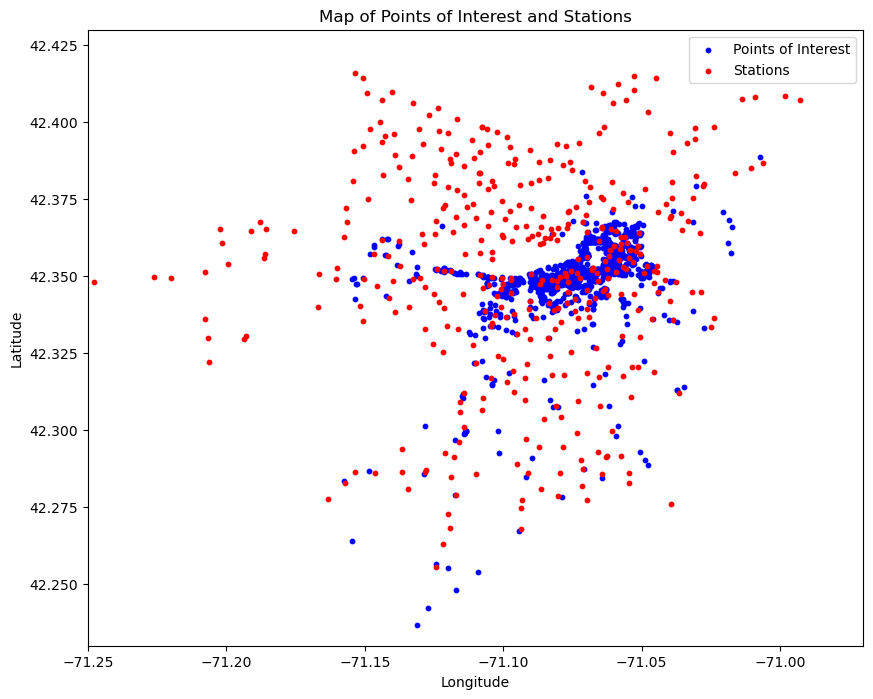

In [40]:
# We want to create a visual representation of how the stations and the points of interest are related with 
# each other geographycally 

# We create the graph
plt.figure(figsize=(10,8)) 

plt.scatter(new_pois['lon'], new_pois['lat'], color='blue', s=10, label='Points of Interest')
plt.scatter(stations['lon'], stations['lat'], color='red', s=10, label='Stations')

# We zoom in to see more details and ignore some of the outliers
lat_min, lat_max = 42.23, 42.43
lon_min, lon_max = -71.25, -70.97

filtered_amenities = new_pois[(new_pois['lat'] >= lat_min) & (new_pois['lat'] <= lat_max) &
                               (new_pois['lon'] >= lon_min) & (new_pois['lon'] <= lon_max)]

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

# We label the graph 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Points of Interest and Stations')
plt.legend()
plt.show()

# Now we can visually see how the stations and the different points of interest are approximatetly distributed throughout the city of Boston

#### 1) Calculate the density of points of interest around each bike station

In [41]:
# First we need to define the haversine function:

def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371  # radius of the Earth in kilometers

# Convert latitudes and longitudes from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

# Calculate differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

# Haversine formula
    a = math.sin(delta_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

# Calculate distance
    distance = r * c
    return distance



# Define the radius for calculating density:

radius = 0.5


# Calculate the distance between each bike station and all points of interest using the haversine_distance function

stations_coords = stations[['lat', 'lon']].values
pois_coords = new_pois[['lat', 'lon']].values

distances = np.zeros((stations_coords.shape[0], pois_coords.shape[0]))

for i in range(stations_coords.shape[0]):
    for j in range(pois_coords.shape[0]):
        lat1, lon1 = stations_coords[i]
        lat2, lon2 = pois_coords[j]
        distances[i, j] = haversine_distance(lat1, lon1, lat2, lon2)
        
        
# Count the number of points of interest within the specified radius for each bike station:

density = np.sum(distances <= radius, axis=1)

In [42]:
# We add the variable density to the data frame stations

stations['density'] = density
stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,daily_idle_time_mean,total_trips,avg_daily_trips,density
0,1,42.387151,-71.075978,676508,2169.0,1053.608384,236,1.447853,0
1,3,42.340115,-71.100619,3626352,395.0,554.414319,8675,23.832418,36
2,4,42.345392,-71.069616,5407780,442.0,579.618493,11996,32.956044,72
3,5,42.341814,-71.090179,2401016,165.0,318.315866,14320,77.826087,21
4,6,42.361257,-71.065287,3465443,166.0,503.323736,21104,57.819178,109
...,...,...,...,...,...,...,...,...,...
415,548,42.268100,-71.119240,8689,1242.0,3050.250000,4,1.000000,0
416,549,42.364739,-71.059349,1500818,558.0,584.315169,2714,29.500000,88
417,550,42.386400,-71.096010,167922,639.0,699.711650,425,5.448718,0
418,553,42.371141,-71.076198,496286,923.0,555.502301,698,11.079365,1


In [43]:
# get rid of density outliers


# Step 1: Calculate the Z-score for the 'density' variable
z_scores = (stations['density'] - stations['density'].mean()) / stations['density'].std()

# Step 2: Set a threshold for outlier removal (e.g., Z-score greater than 3 or less than -3)
outlier_threshold = 3

# Step 3: Filter the 'stations' data frame to remove outliers
stations = stations[abs(z_scores) <= outlier_threshold]

#### 2) Regression between density and daily idle time mean

C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\553906613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations.dropna(subset=['density', 'daily_idle_time_mean'], inplace=True)


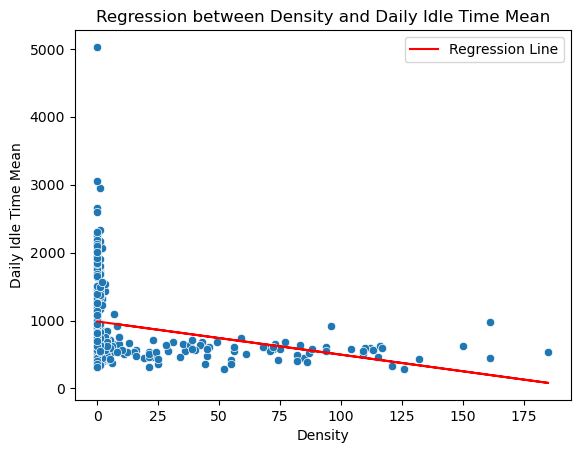

In [44]:
# Step 1: Drop any rows with missing values in the columns of interest
stations.dropna(subset=['density', 'daily_idle_time_mean'], inplace=True)

# Step 2: Calculate the regression
slope, intercept, r_value, p_value, std_err = linregress(stations['density'], stations['daily_idle_time_mean'])

# Step 3: Create the scatter plot with regression line
sns.scatterplot(x='density', y='daily_idle_time_mean', data=stations)
plt.plot(stations['density'], intercept + slope * stations['density'], color='red', label='Regression Line')

# Step 4: Customize the plot
plt.xlabel('Density')
plt.ylabel('Daily Idle Time Mean')
plt.title('Regression between Density and Daily Idle Time Mean')
plt.legend()

# Step 5: Show the plot
plt.show()

In [45]:
# Step 1: Drop any rows with missing values in the columns of interest
stations.dropna(subset=['density', 'daily_idle_time_mean'], inplace=True)

# Step 2: Calculate the regression
slope, intercept, r_value, p_value, std_err = linregress(stations['density'], stations['daily_idle_time_mean'])

# Step 3: Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-value (correlation coefficient): {r_value}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

Slope: -4.891779632433967
Intercept: 985.9424084998265
R-value (correlation coefficient): -0.26009284985605646
P-value: 1.0211371645683401e-07
Standard Error: 0.9024036542320907


C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\2228671794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations.dropna(subset=['density', 'daily_idle_time_mean'], inplace=True)


#### Regression between density and average daily trips 

C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\2347131169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations.dropna(subset=['density', 'avg_daily_trips'], inplace=True)


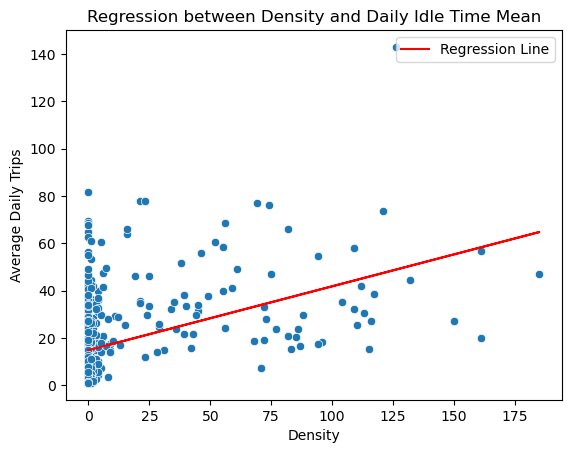

In [46]:
# Step 1: Drop any rows with missing values in the columns of interest
stations.dropna(subset=['density', 'avg_daily_trips'], inplace=True)

# Step 2: Calculate the regression
slope, intercept, r_value, p_value, std_err = linregress(stations['density'], stations['avg_daily_trips'])

# Step 3: Create the scatter plot with regression line
sns.scatterplot(x='density', y='avg_daily_trips', data=stations)
plt.plot(stations['density'], intercept + slope * stations['density'], color='red', label='Regression Line')

# Step 4: Customize the plot
plt.xlabel('Density')
plt.ylabel('Average Daily Trips')
plt.title('Regression between Density and Daily Idle Time Mean')
plt.legend()

# Step 5: Show the plot
plt.show()

In [47]:
# Step 1: Calculate the regression
slope, intercept, r_value, p_value, std_err = linregress(stations['density'], stations['avg_daily_trips'])

# Step 2: Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-value (correlation coefficient): {r_value}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

Slope: 0.2697275068198814
Intercept: 14.849506499795472
R-value (correlation coefficient): 0.4298015908795331
P-value: 9.970058586989174e-20
Standard Error: 0.02815662497581769


## Weather and idle time 

In [48]:
bikes.sort_values("start_time", inplace=True)

bikes_weather_info = pd.merge_asof(bikes, weather, left_on="start_time", right_on="timestamp", direction="nearest")

In [49]:
#here we calculate the bike idle time average for every day to see when the idle time was highest (season, weather ...)

bikes_idle_avg = bikes.groupby(pd.PeriodIndex(bikes['start_time'], freq="D"))['idle_time_minutes'].mean() 

bikes_idle_avg

start_time
2021-01-01    1368.488346
2021-01-02    1205.746820
2021-01-03    1386.459972
2021-01-04     978.918487
2021-01-05    1026.875314
                 ...     
2021-12-27     834.176309
2021-12-28     660.968023
2021-12-29     598.342197
2021-12-30     481.722731
2021-12-31     117.126323
Freq: D, Name: idle_time_minutes, Length: 365, dtype: float64

In [50]:
#here we calculate the weather average for every week, to merge it with the average idle time 

weather_temp_avg = weather.groupby(pd.PeriodIndex(weather['timestamp'], freq="D"))['temperature'].mean() 
weather_temp_avg

timestamp
2021-01-01    0.913043
2021-01-02    3.772727
2021-01-03    0.551724
2021-01-04    1.000000
2021-01-05   -0.250000
                ...   
2021-12-27    0.640000
2021-12-28    2.648649
2021-12-29    4.862069
2021-12-30    4.555556
2021-12-31    5.615385
Freq: D, Name: temperature, Length: 365, dtype: float64

In [51]:
# merged table for weather and bikes idle time average

weather_idle = weather_temp_avg.to_frame().join(bikes_idle_avg)
weather_idle

,temperature,idle_time_minutes
timestamp,,
2021-01-01,0.913043,1368.488346
2021-01-02,3.772727,1205.746820
2021-01-03,0.551724,1386.459972
2021-01-04,1.000000,978.918487
2021-01-05,-0.250000,1026.875314
...,...,...
2021-12-27,0.640000,834.176309
2021-12-28,2.648649,660.968023
2021-12-29,4.862069,598.342197


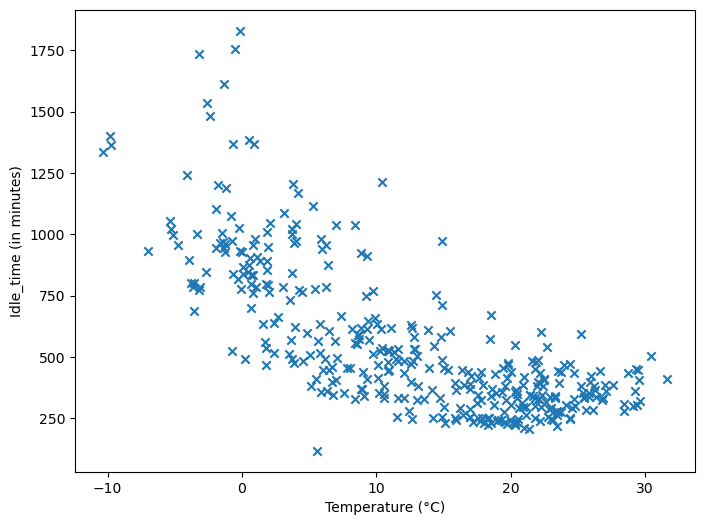

In [52]:
xp = weather_idle['idle_time_minutes'].values
yp = weather_idle['temperature'].values
plt.figure(figsize = (8,6))
plt.scatter(yp, xp, marker="x")
plt.xlabel("Temperature (°C)")
plt.ylabel("Idle_time (in minutes)")
plt.show()

[ 422.17297598 -547.3331849   512.9292456 ]


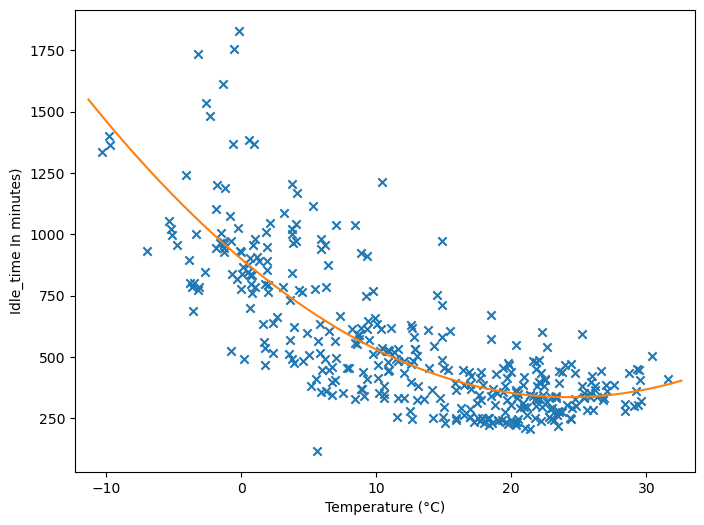

In [53]:
def plot_regression_poly(x, y, d):
    
    # create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T # start at highest polynomial degree (d) and go backwards until 0 in steps of 1
    
    # implement polynomial regression using least squares (we use the normal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    
    # create scaled test dataset
    xt0 = np.linspace(min_x-1, max_x+1, 400) # generate equally spaced x values in the x range
    xt = 2 * (xt0 - min_x)/(max_x - min_x) -1 # standardize to range [-1,1]
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T # generate polynomial features
    yt = Xt @ theta # generate predicted y values
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Idle_time In minutes)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:7]) # print first 7 thetas
    
plot_regression_poly(x = yp, y=xp, d = 2)

In [54]:
# Step 1: Calculate the regression
slope, intercept, r_value, p_value, std_err = linregress(weather_idle['temperature'], weather_idle['idle_time_minutes'])

# Step 2: Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-value (correlation coefficient): {r_value}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

Slope: -23.896962120052997
Intercept: 854.682147265037
R-value (correlation coefficient): -0.747014187261757
P-value: 2.433201762593498e-66
Standard Error: 1.1162380744112927


## Predictive Model

In [55]:
# Step 1: Aggregate the bike usage data to hourly level
hourly_bike_usage = bikes.resample('H', on='start_time').count().reset_index()
hourly_bike_usage = hourly_bike_usage[['start_time', 'bike_id']]
hourly_bike_usage.columns = ['date', 'total_trip_count']

hourly_bike_usage

,date,total_trip_count
0,2021-01-01 00:00:00,83
1,2021-01-01 01:00:00,65
2,2021-01-01 02:00:00,63
3,2021-01-01 03:00:00,41
4,2021-01-01 04:00:00,31
...,...,...
8755,2021-12-31 19:00:00,251
8756,2021-12-31 20:00:00,294
8757,2021-12-31 21:00:00,269
8758,2021-12-31 22:00:00,169


In [56]:
# Step 2: Impute or aggregate the weather data to hourly level
# For example, if your weather data has timestamps and you want to calculate hourly averages:

weather['timestamp'] = pd.to_datetime(weather['timestamp'])

daily_weather = weather.resample('H', on='timestamp').mean().reset_index()

# Step 3: Aggregate the weather data to daily level

daily_weather = weather.resample('H', on='timestamp').mean().reset_index()

# Step 4: Merge the aggregated data
combined_data = pd.merge(hourly_bike_usage, daily_weather, left_on='date', right_on='timestamp', how='left')
combined_data.drop(columns=['timestamp'], inplace=True)

C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\3608334544.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_weather = weather.resample('H', on='timestamp').mean().reset_index()
C:\Users\Laura\AppData\Local\Temp\ipykernel_20412\3608334544.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_weather = weather.resample('H', on='timestamp').mean().reset_index()


#### Feature Engineering 

In [57]:
# Date Features
combined_data['day_of_week'] = combined_data['date'].dt.dayofweek
combined_data['month'] = combined_data['date'].dt.month
combined_data['season'] = combined_data['date'].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})

weather_features = ['temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation', 'felt_temperature']

combined_data.dropna(inplace=True)

In [58]:
combined_data

,date,total_trip_count,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,day_of_week,month,season
0,2021-01-01 00:00:00,83,3.0,29.0,1023.99,17.0,0.0,-2.0,4,1,Winter
1,2021-01-01 01:00:00,65,2.0,33.0,1025.68,15.0,0.0,-2.0,4,1,Winter
2,2021-01-01 02:00:00,63,2.0,33.0,1026.02,13.0,0.0,-2.0,4,1,Winter
3,2021-01-01 03:00:00,41,2.0,33.0,1026.70,15.0,0.0,-3.0,4,1,Winter
4,2021-01-01 04:00:00,31,1.0,33.0,1027.38,15.0,0.0,-4.0,4,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31 19:00:00,251,7.0,26.0,1013.84,9.0,0.0,4.0,4,12,Winter
8756,2021-12-31 20:00:00,294,7.0,26.0,1013.84,6.0,0.0,7.0,4,12,Winter
8757,2021-12-31 21:00:00,269,6.0,26.0,1014.18,11.0,0.0,3.0,4,12,Winter
8758,2021-12-31 22:00:00,169,6.0,26.0,1014.01,8.5,0.0,4.5,4,12,Winter


In [59]:
df_merged = pd.merge(bikes, stations, left_on='start_station_id', right_on='station_id', how='left')
df_merged = pd.merge_asof(df_merged.sort_values('start_time'), combined_data.sort_values('date'), left_on='start_time', right_on='date', direction='nearest')

df_merged

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,...,total_trip_count,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,day_of_week,month,season
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316,...,83,3.0,29.0,1023.99,17.0,0.0,-2.0,4,1,Winter
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917,...,83,3.0,29.0,1023.99,17.0,0.0,-2.0,4,1,Winter
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881,...,83,3.0,29.0,1023.99,17.0,0.0,-2.0,4,1,Winter
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792,...,83,3.0,29.0,1023.99,17.0,0.0,-2.0,4,1,Winter
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062,...,83,3.0,29.0,1023.99,17.0,0.0,-2.0,4,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906259,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895,...,187,7.0,26.0,1014.18,7.0,0.0,5.0,4,12,Winter
2906260,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665,...,187,7.0,26.0,1014.18,7.0,0.0,5.0,4,12,Winter
2906261,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470,...,187,7.0,26.0,1014.18,7.0,0.0,5.0,4,12,Winter
2906262,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484,...,187,7.0,26.0,1014.18,7.0,0.0,5.0,4,12,Winter


In [60]:
# Time of the day feature 
# we can divide the 24 hours into 4 periods which are morning (5 to 12), afternoon (12 to 17), evening (17 to 21), 
# and night (21 to 5)

def assign_time_of_day(hour):
    if (hour >= 5) & (hour < 12):
        return 'Morning'
    elif (hour >= 12) & (hour < 17):
        return 'Afternoon'
    elif (hour >= 17) & (hour < 21):
        return 'Evening'
    else:
        return 'Night'

df_merged['time_of_day'] = df_merged['start_hour'].apply(assign_time_of_day)

In [61]:
# Peak hour: merge average_trip_count DataFrame

df_merged['hour'] = df_merged['start_time'].dt.hour

df_merged = pd.merge(df_merged, average_trip_count_per_hour, on='hour', how='left')


In [62]:
df_merged

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,...,pressure,windspeed,precipitation,felt_temperature,day_of_week,month,season,time_of_day,hour,average_trip_count_per_hour
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316,...,1023.99,17.0,0.0,-2.0,4,1,Winter,Night,0,382.0
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917,...,1023.99,17.0,0.0,-2.0,4,1,Winter,Night,0,382.0
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881,...,1023.99,17.0,0.0,-2.0,4,1,Winter,Night,0,382.0
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792,...,1023.99,17.0,0.0,-2.0,4,1,Winter,Night,0,382.0
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062,...,1023.99,17.0,0.0,-2.0,4,1,Winter,Night,0,382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906259,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895,...,1014.18,7.0,0.0,5.0,4,12,Winter,Night,23,552.0
2906260,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665,...,1014.18,7.0,0.0,5.0,4,12,Winter,Night,23,552.0
2906261,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470,...,1014.18,7.0,0.0,5.0,4,12,Winter,Night,23,552.0
2906262,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484,...,1014.18,7.0,0.0,5.0,4,12,Winter,Night,23,552.0


### Predictive Model 

In [ ]:
# Define preprocessing steps
numeric_features = ['temperature','cloud_cover', 'pressure', 'windspeed', 'precipitation', 'felt_temperature','daily_idle_time_mean', 'avg_daily_trips', 'density']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['time_of_day', 'day_of_week', 'season']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Define your X (features) and y (target)
X = df_merged.drop('idle_time_minutes', axis=1)
y = df_merged['idle_time_minutes']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate model
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))



In [70]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 945.8616859538535
